<a href="https://colab.research.google.com/github/scottie1013/SVD-application/blob/main/Shihao_Wang_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 (The Singular Faces)
# Lin. Alg. for Data Science. 
## Due date: hopefully a reasonable one, see discord



# Instructions:
0. Solve the tasks (by writing python code and answering extra questions). 
1. Prefix the name of the notebook with your name (e.g. Minecraft_Steve_HW3.ipynb)
2. Run all the cells in the notebook, so that all results are visible.

3. > Important: on colab create a shared link using the option **"for anyone with the link"** and switch permission from **Viewer** to **Editor**, so that it says "Anyone on the internet with the link can edit".

4. Submit the above link on canvas before the deadline. Do not modify the notebook after that.

5. The day after the final deadline, **you will be required to answer** some brief questions about your solution via a google form I will send you. This is part of the homework assignment! 

> This time I will also ask you to copy-paste some of your answers from this notebook to the form.


# Collaboration rules:
> For this task, I'd prefer if you worked on your own -- at least for the first period of the assignment. We'll open up the discussion at some point. 

There is not too much programming here, and the challenge is more conceptual. I'd like everyone to think about this on their own, piece things together and get some insights.

# Instructions
0. Please **do not discuss your solutions** this time and **do not share python code**.
1. Solve the tasks by writing python code.
2. Describe what you did in each part.
4. Fill in your name and the link to your shared notebook above. **Do make sure it's shared with 'anyone with the link' and clickable also when exported to pdf** 
5. Run all the cells, so that all results are visible.
6. DON'T save your notebook to a pdf.
7. Submit the link on canvas

Followup:
After the due date you will get a link to a brief survey in which you will answer a couple of questions about the work you did here.

> Important: for readability please format your answers like this.

# Overview

The idea is to use SVD as a dimensionality reduction tool, and construct a nearest neighbour classifier in this new space. 

Our dataset is a collection of high-quality images of faces of a groups of people (with repetitions). The resulting classifier will assign a new, unseen photo to a person.

Our main learning objective is to understand this lower-dimensional represention given by SVD.

This assignment is guided less tightly than the previous two assignents. With the information from the past lectures you should be able to complete it. 

# Data

We use a classical dataset with photos of faces. It contains faces of 40 people, 10 photos per person with different angle and/or expression (neutral, smiling etc). To make things interesting, I additionally augment the data a little, with rotations, shears, zooms etc.

> Hint: You will treat each image as a vector (like we did with kMeans, tSNE etc.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#@title
# below we just load the data, you can ignore it
import itertools
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

W = 64

def augment(x, y, num):
  gen = ImageDataGenerator(rotation_range = 3, shear_range = 3, 
                           zoom_range = 0.1, horizontal_flip = False)
  it = gen.flow(x.reshape((-1,W,W,1)), y, batch_size = 1)
  xy = itertools.islice(it, num)
  x,y = zip(*xy)
  return np.array(x).squeeze(), np.array(y).squeeze()

def get_faces_data(n_train, n_test):
  images = fetch_olivetti_faces()['images']
  labels = np.array(range(len(images)))//10
  x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 50)
  x_train, y_train = augment(x_train, y_train, n_train)  
  x_test, y_test = augment(x_test, y_test, n_test)

  return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = get_faces_data(n_train = 2_000, n_test = 10_000)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


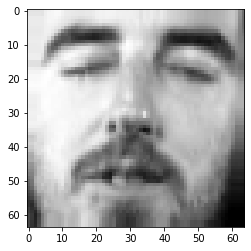

In [ ]:
#plt.imshow(x_train[7], cmap = 'gray')
plt.imshow(x_train[58],cmap='gray')

# Part 1: finding a new basis

**Objective**: Use SVD to find a basis of the matrix representing the train data. Later this will allow you to perform dimensionality reduction by choosing only the important basis vectors.

> Remember what is the default basis for images! We discussed it and it's mentioned in one notebook.

Guidelines and restrictions:
- SVD decomposition will give you the basis vectors.
- SVD will also tell you which of the vectors are important.
- You **must** do it using SVD (**use only np.linalg.svd**). There are other ways of doing this, but this is meant to show you something very specific about basis vectors. It may be hard but should be enlightening.
- In particular don't use existing libraries from the dimensionality reduction part -- they may be convenient but they will hide important details you should understand.
- The basis you create on the train data **must** be also used for the test data. (It's not okay to compute another basis based on the test data.)
- It's not about random projections (although some parts are similar so going back to that may be useful).
- During class we did (or will do on 11/28) rank-k approximation using SVD on a **single image** -- this is similar, but we now work with a collection of images. So we can go back to thinking about a single image as a vector in a high-dimensional space.



In [ ]:
x_train = x_train.reshape(2000,64*64)

In [ ]:
x_test = x_test.reshape(10000,64*64)

In [ ]:
U,S,Vt = np.linalg.svd(x_train)

# Part 2: Exploring the new basis

**Objective**: Visualize (some of) the new basis vectors. (If it's not clear what I mean, go back to the lectures and rethink what's happening.) 

Looking at the visualization -- what does the *most important* basis vector represent? How about a couple other ones?



The most important basis vector here is the first row of the Vt matrix which captures most of the information in our face image dataset, the second row of Vt would be the second most influential and so on.

In [ ]:
from scipy.linalg import diagsvd

In [ ]:
def plot_images_in_a_row(ims):    
  'Takes a list/array of images and plots them spaced horizontally.'
  _, axs = plt.subplots(1, len(ims), figsize = (20,5))
  for im, ax in zip(ims, axs.ravel()):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')

In [ ]:
Vt_basis = [Vt[i,:].reshape(64,64) for i in range(10)]

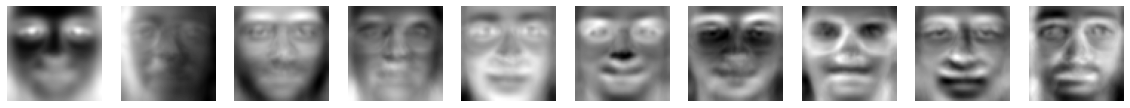

In [ ]:
plot_images_in_a_row(Vt_basis)

# Part 3: Expressing images in the new basis

Find a way to express (represent) any image (in particular from the test dataset!) in your 
new basis. Ideally, find the simplest way possible.

> Now each image should be a vector of size $64^2$, but each coordinate corresponds to a non-standard basis element.

**Objective**: express (represent) all train and test images in this new basis.

> Hint: If this is unclear, we did something related when we talked about random projections. However, the goal is *not* to do random projections here. Use what SVD gives you.

In [ ]:
x_test.shape

(10000, 4096)

In [ ]:
x_new = x_test @ Vt

In [ ]:
x_new.shape

(10000, 4096)

# Part 4: Reconstructing images

Pick 5 vectors, each representing an image from the **test dataset** in the new basis. Write code which goes back to the standard basis and visualizes the images. 

**Objective**: Verify that the images you obtained this way are similar (identical?) to the original ones? Plot them side by side. 

> Mathematically we know what should happen, but there may be numerical issues during computing SVD. So we're double checking.

In [ ]:
x_back = x_new @ Vt.T

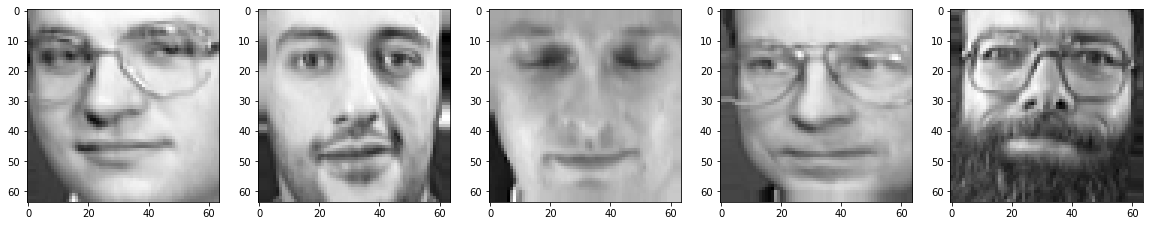

In [ ]:
#plot the reduced images
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range (5):
    axs[i].imshow(x_back[i].reshape(64,64), cmap = 'gray')
plt.show()

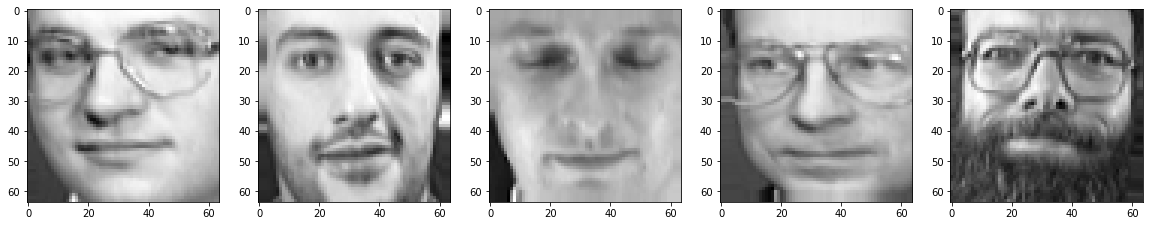

In [ ]:
#comparing it to the original images
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range (5):
    axs[i].imshow(x_test[i].reshape(64,64), cmap = 'gray')
plt.show()

Indeed the images are identical to the original onesby plotting both the original and the image with the new basis

# Part 5: Representing images in the new truncated basis

Implement a function which expresses (represents) each image a collection of images (either from the train or test dataset or any other images of same shape) as a vector of $r$ coordinates. The resulting vector must represent the coordinates in the $r$ most prominent new basis vectors you computed earlier. (In other words these should be coordinates in a truncated basis.). $r$ should be a parameter of the function.

> Ideally, find the simplest way possible to do this computations. Once you know what you want the code should be straightforward.

> Note that the resulting $r$ dimensional vector not meant as a human readable representation.

**Objective**: Reduce the dimensionality of all the train and test images.

> The coordinates **must** come from the basis computed for the train dataset using SVD. Try to make SVD work, it will be worth it.




In [ ]:
def image_truncate(old,r):
  # Compute SVD of x_train
  U, s, V = np.linalg.svd(x_train, full_matrices=False)
  
  # Truncate the svd by keeping the first r singular values
  U_r = U[:,:r]
  s_r = s[:r]
  V_r = V[:r,:]
  
  # Calculate the coordinates of each image in the new basis
  #x_train_r = np.dot(U_r, np.diag(s_r))
  x_r = old @ V_r.T 
  
  return x_r

# Part 6 (extra): Guessing a reasonable $r$

**Objective**: Write some code to make an informed decision about a reasonable of $r$ (before visualizing the results in the next part). SVD should provide some hints. 

> Q: What was the number you arrived at? Briefly justify your approach.

> A: ...

# Part 7: Reconstructing approximate images (important!)

Pick $r$-dimensional vectors of 5 selected images from the **test dataset**. Visualize the images they represent -- show the results for different values of $r$. Tune your choice of $r$ based on what you see.

> The reconstruction does not have to be perfect, but some characteristic facial features should be present. Check for a couple of images, sometimes it may work better sometimes worse. 

**Objective**: understand how many basis vectors are needed.

> Q: Briefly describe your process of choosing the right $r$.

> A: I basically compared the reucded images to the original ones and see if there are any prominent features missing and then choose the r that with least features loss comparing to the original picture.Based on the visulization, 25 is a good enough estimation and cupures most of the information from the orginal picture, it also has a high enough accuracy score when applying prediction using KNN

In [ ]:
x_test_r = image_truncate(x_test, 25)

In [ ]:
x_reconstruct = x_test_r @ Vt[:25]

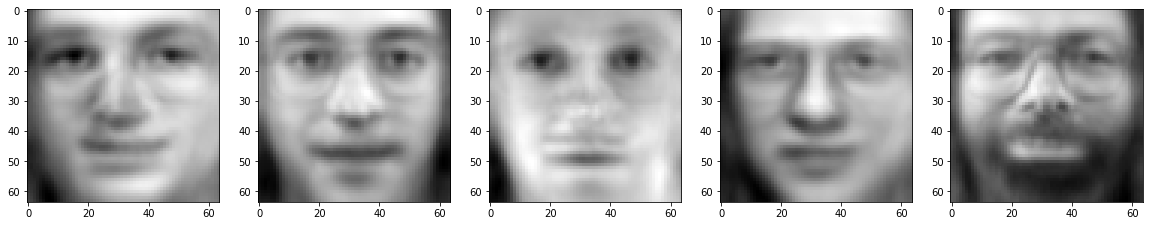

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range (5):
    axs[i].imshow(x_reconstruct[i].reshape(64,64), cmap = 'gray')
plt.show()

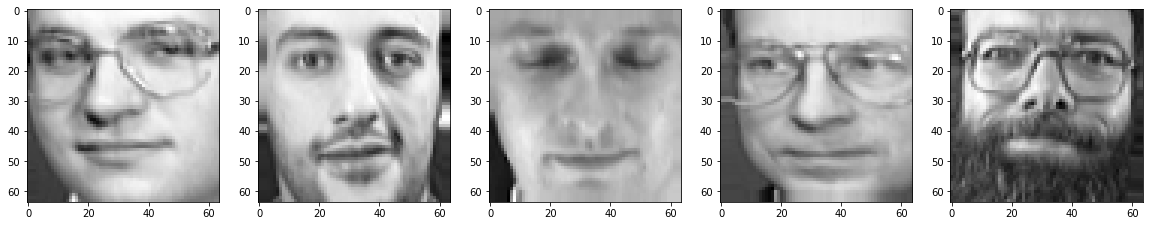

In [ ]:
#comparing it to the original images
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range (5):
    axs[i].imshow(x_test[i].reshape(64,64), cmap = 'gray')
plt.show()

# Part 8: Final data reduction

Based on the observation from the last point, choose your $r$ -- the number of basis vector you will use. (No worries: you'll get to tune it later based on more objective criteria.)

**Objective**: Perform your dimensionality reduction of the train and test dataset. 

> Again just use the information coming from SVD on the train data only!

In [ ]:
x_train_reduced = image_truncate(x_train, 25)
x_test_reduced = image_truncate(x_test, 25)

# Part 9: Classification in the reduced space

**Objective**: Construct, train, test and tune your $k$-nearest neighbours classifier using the $r$-dimensional representation. 

> In particular, remember to train on the dimensionality-reduced train data and test on the dimensionality-reduced test data.

> Again, you must use the data obtained from SVD.

You can simple use the KNeighborsClassifier imported above (it uses a kd-tree or a similar efficient data-structure internally).

Keep in mind that kd-trees (and similar data-strucures) get slow when the dimension exceeds $100$.


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)

In [ ]:
neigh.fit(x_train_reduced, y_train)

KNeighborsClassifier(n_neighbors=1)

# Part 10: The final test

Fix your final $r$ and other parameters and train the classifier using reduced data for these parameters. 

> Note that you don't have to re-compute the SVD. Just recompute whatever depends on the parameter $r$.

> It should be clear by now -- but you must use the data obtained from SVD in the previous steps as described. 

**Objective**: Get $>90\%$ accuracy on the **test set** **and** keep the running time on the entire test set below $1$ second.

Note: The train dataset could be much larger (millions of images or more), so reducing the dimension would make even more sense. But we'd need a smarter algorithm for SVD, so we just keep it simple (see bonus).



In [ ]:
predicted = neigh.predict(x_test_reduced)

In [ ]:
acc = accuracy_score(y_test, predicted)
print(acc)

0.9581


# Part 11: Just out of curiosity

Redo part 7 with your final value of $r$. 

**Objective**: Understand the quality of the images neccesery to get 90% accuracy.

> Q: Are the images human recognizable for the final $r$? Were you expecting lower or higher quality images to get the desired accuracy? Answer briefly below.

> A: yes, the images are human recognizable for the final r, I would except a higher quality image to get this desired accurarcy since by eyeballing it I can still tell a decent chunk of difference between the reduced and the orginal
images 



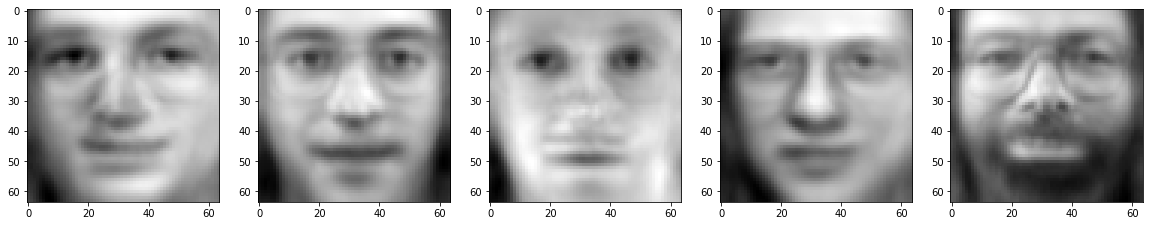

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range (5):
    axs[i].imshow(x_reconstruct[i].reshape(64,64), cmap = 'gray')
plt.show()

#Bonus

- How well would the algorithm work if the faces were masked (covid-style)? You can simulate it for example by replacing the lower portion of the image with a black patch or something. Easily done with numpy masking. Do you need more basis vectors to get the same accuracy?

- The algorithm for SVD used by numpy is okay but computes the entire decomposition. Sklearn has a nice implementation for truncated SVD -- which will likely be much more efficient. Try to use it. Maybe you can increase the number of images generated in the image augmentation phase in the code on the top.

Indeed, the accuracy significantly decreased after the replacement of the lower portion of the picture and we need more basis vector get a higher accuracy, when using the same r we get an accuracy of 0.93. When we raise r to 50 we get a similar accuarcy around 0.958

In [ ]:
mask = np.ones(x_test.shape)
mask[:, 3000:] = 0

mask2 = np.ones(x_train.shape)
mask2[:, 3000:] = 0

test_images = np.multiply(x_test, mask)
train_images = np.multiply(x_train, mask2)

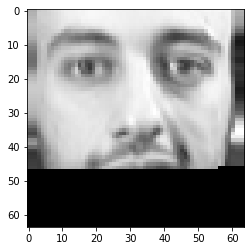

In [ ]:
plt.imshow(test_images[1].reshape(64,64), cmap='gray')

In [ ]:
x_train_reduced = image_truncate(train_images, 25)
x_test_reduced = image_truncate(test_images, 25)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)

In [ ]:
neigh.fit(x_train_reduced, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predicted = neigh.predict(x_test_reduced)

In [ ]:
acc = accuracy_score(y_test, predicted)
print(acc)

0.934


In [ ]:
x_train_reduced = image_truncate(train_images, 50)
x_test_reduced = image_truncate(test_images, 50)

In [ ]:
neigh.fit(x_train_reduced, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predicted = neigh.predict(x_test_reduced)

In [ ]:
acc = accuracy_score(y_test, predicted)
print(acc)

0.9583
